# Lending Club loan data

El presente proyecto tiene como objetivo probar diferentes modelos de aprendizaje automático para determinar si un cliente tendrá problemas con el pago de su deuda o no,  de acuerdo a diversas características como el riesgo o incumplimiento por parte del prestatario a lo largo de los años.

https://www.kaggle.com/wordsforthewise/lending-club

In [ ]:
import io
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
%matplotlib inline
pd.options.display.max_rows = 1000

In [ ]:
%ls

accepted_2007_to_2018Q4.csv.gz  LCDataDictionary-esp.xlsx
data_acc_20k.csv                sample_data/


# **Procesamiento de la data inicial**

In [ ]:
data_acc = pd.read_csv('accepted_2007_to_2018Q4.csv.gz', compression='gzip', low_memory=False)
data_acc.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,...,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,...,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,...,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,NaN,NaN,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,...,381215.0,52226.0,62500.0,18000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,...,439570.0,95768.0,20300.0,88097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_acc.shape

(2260701, 151)

In [ ]:
data_acc['loan_status'].value_counts() 

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [ ]:
data_acc['loan_status'].value_counts() / data_acc.shape[0] * 100

Fully Paid                                             47.629076
Current                                                38.851533
Charged Off                                            11.879457
Late (31-120 days)                                      0.949573
In Grace Period                                         0.373159
Late (16-30 days)                                       0.192374
Does not meet the credit policy. Status:Fully Paid      0.087937
Does not meet the credit policy. Status:Charged Off     0.033662
Default                                                 0.001769
Name: loan_status, dtype: float64

In [ ]:
# "Fully Paid" y "Current" son clientes que estan cumpliendo con sus pagos a tiempo o q ya terminaron de cancelar 
# "Charged Off" no pagada
# Los siguientes valores tienen ruido por guardar hacer overload al dato:
    # "Does not meet the credit policy. Status:Fully Paid" == Fully Paid 
    # "Does not meet the credit policy. Status:Charged Off" == Charged Off 
# No considerar el campo "Default"

In [ ]:
data_dictionary = pd.read_excel("LCDataDictionary-esp.xlsx")

In [ ]:
data_dictionary

,LoanStatNuevo,Descripción
0,acc_now_delinq,El número de cuentas en las que el prestatario...
1,acc_open_past_24mths,Número de operaciones abiertas en los últimos ...
2,addr_state,El estado proporcionado por el prestatario en ...
3,all_util,Saldo al límite de crédito en todas las operac...
4,annual_inc,El ingreso anual autoinformado proporcionado p...
5,annual_inc_joint,El ingreso anual autoinformado combinado propo...
6,application_type,Indica si el préstamo es una solicitud individ...
7,avg_cur_bal,Saldo actual promedio de todas las cuentas
8,bc_open_to_buy,Total abierto para comprar con tarjetas bancar...
9,bc_util,Relación entre el saldo actual total y el lími...


In [ ]:
for i in data_dictionary.values:
    if str(i[0]) == 'loan_status':
        print(str(i[0]) + ':: \n\t ' + str(i[1]))
        print()

loan_status:: 
	 Estado actual del préstamo



In [ ]:
data_acc_20k = data_acc.sample(frac=0.010, axis=0, random_state=42).reset_index(drop=True)

In [ ]:
data_acc_20k.shape

(22607, 151)

In [ ]:
data_acc_20k['loan_status'].value_counts() 

Fully Paid                                             10747
Current                                                 8747
Charged Off                                             2718
Late (31-120 days)                                       237
In Grace Period                                           84
Late (16-30 days)                                         54
Does not meet the credit policy. Status:Fully Paid        12
Does not meet the credit policy. Status:Charged Off        8
Name: loan_status, dtype: int64

In [ ]:
data_acc_20k['loan_status'].value_counts() / data_acc_20k.shape[0] * 100

Fully Paid                                             47.538373
Current                                                38.691556
Charged Off                                            12.022825
Late (31-120 days)                                      1.048348
In Grace Period                                         0.371566
Late (16-30 days)                                       0.238864
Does not meet the credit policy. Status:Fully Paid      0.053081
Does not meet the credit policy. Status:Charged Off     0.035387
Name: loan_status, dtype: float64

In [ ]:
# En el subconjunto de dato se mantiene la relación de los totales de cada clase
data_acc_20k.head(2).T

,0,1
id,39651438,16411620
member_id,NaN,NaN
loan_amnt,32000,9600
funded_amnt,32000,9600
funded_amnt_inv,32000,9600
term,60 months,36 months
int_rate,10.49,12.99
installment,687.65,323.42
grade,B,C
sub_grade,B3,C1


In [ ]:
data_acc_20k.to_csv("data_acc_20k.csv")

In [ ]:
loans = pd.read_csv('data_acc_20k.csv', low_memory=False)
loans.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,0,39651438,NaN,32000.0,32000.0,32000.0,60 months,10.49,687.65,B,B3,Public Service,10+ years,MORTGAGE,120000.0,Verified,Feb-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,919xx,CA,24.05,0.0,Oct-1981,735.0,739.0,0.0,NaN,NaN,20.0,0.0,39687.0,57.8,42.0,w,7181.91,...,556496.0,103647.0,64100.0,72197.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1,16411620,NaN,9600.0,9600.0,9600.0,36 months,12.99,323.42,C,C1,NaN,NaN,RENT,21900.0,Verified,May-2014,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,331xx,FL,10.03,0.0,Apr-2001,685.0,689.0,1.0,NaN,118.0,13.0,1.0,4509.0,38.9,20.0,w,0.00,...,11600.0,4509.0,2400.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,2,45122316,NaN,4000.0,4000.0,4000.0,36 months,6.68,122.93,A,A3,System Analyst,4 years,MORTGAGE,83000.0,Not Verified,Apr-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,333xx,FL,19.53,0.0,Sep-2003,780.0,784.0,0.0,NaN,NaN,16.0,0.0,1564.0,17.2,25.0,w,0.00,...,222616.0,64253.0,5600.0,76154.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,3,125356772,NaN,6025.0,6025.0,6025.0,36 months,10.91,197.00,B,B4,Admin assistant,10+ years,RENT,52000.0,Not Verified,Dec-2017,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,021xx,MA,9.16,1.0,Jun-2005,740.0,744.0,1.0,15.0,NaN,11.0,0.0,2706.0,12.8,25.0,w,0.00,...,32227.0,5559.0,11000.0,11127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,4,128490686,NaN,25000.0,25000.0,25000.0,60 months,26.30,752.96,E,E5,Coordinator,10+ years,OWN,65000.0,Verified,Feb-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,926xx,CA,36.26,0.0,Jul-1999,715.0,719.0,1.0,37.0,NaN,19.0,0.0,49461.0,24.7,33.0,w,21954.14,...,257219.0,97647.0,179400.0,65719.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data=loans

In [ ]:
loans.shape

(22607, 152)

# **Estadistica descriptiva**

In [ ]:
loans['loan_status'].value_counts()

Fully Paid                                             10747
Current                                                 8747
Charged Off                                             2718
Late (31-120 days)                                       237
In Grace Period                                           84
Late (16-30 days)                                         54
Does not meet the credit policy. Status:Fully Paid        12
Does not meet the credit policy. Status:Charged Off        8
Name: loan_status, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribución del monto del préstamo')

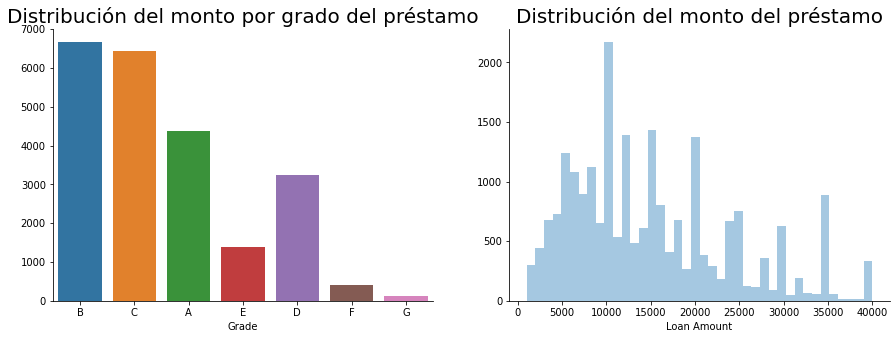

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15,5))
sns.countplot(x='grade', data=loans, ax=axes[0])
sns.distplot(loans['loan_amnt'], kde=False, bins=40, ax=axes[1])
sns.despine()
axes[0].set(xlabel='Grade', ylabel='')
axes[0].set_title('Distribución del monto por grado del préstamo', size=20)
axes[1].set(xlabel='Loan Amount', ylabel='')
axes[1].set_title('Distribución del monto del préstamo', size=20)

Text(0.5, 1.0, 'Diagrama de dispersión entre Loan Amount y Installment')

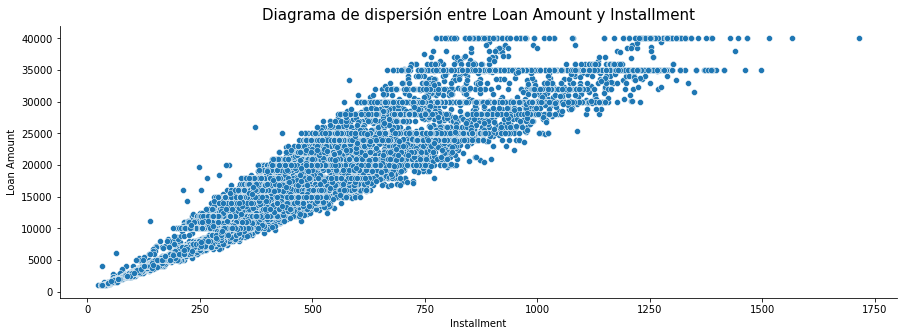

In [ ]:
f, axes = plt.subplots(1, 1, figsize=(15,5))
sns.scatterplot(x='installment', y='loan_amnt', data=loans, ax=axes)
sns.despine()
axes.set(xlabel='Installment', ylabel='Loan Amount')
axes.set_title('Diagrama de dispersión entre Loan Amount y Installment', size=15)

In [ ]:
loans = loans.drop(loans.loc[:, loans.isna().mean().sort_values() > 0.3].columns, axis=1)
loans.shape

(22607, 94)

Text(15.835887896825405, 0.5, 'loan_amnt')

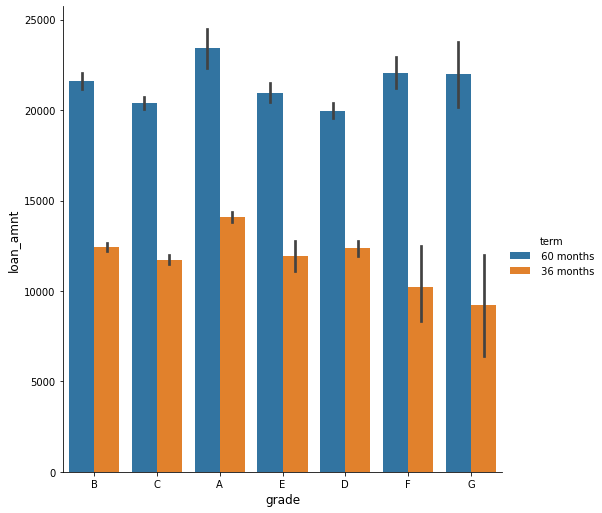

In [ ]:
#Número de pagos de la deuda (60 meses o 36 meses) por grado y monto del préstamo
#se evidencia que los montos más altos se pagan con en 60 meses
sns.catplot(x="grade", y="loan_amnt", hue="term", kind="bar", data=loans,height = 7, aspect = 1)
plt.xlabel("grade",fontsize=12)
plt.ylabel("loan_amnt",fontsize=12)

Text(0.5, 1.0, 'Distribución de la tasa de interés cobrada por cada grado del préstamo')

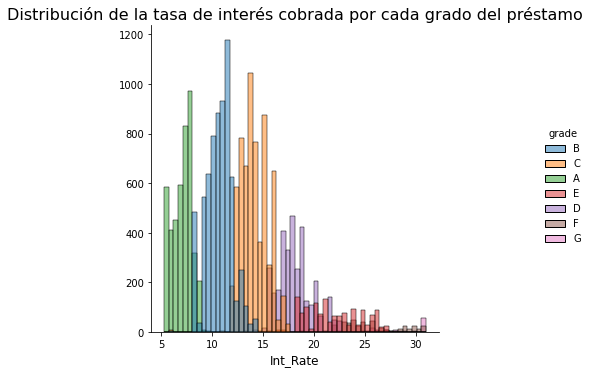

In [ ]:
b=sns.displot(loans, x="int_rate", hue="grade", height = 5, aspect = 1, kde=False)
plt.xlabel("Int_Rate",fontsize=12)
plt.ylabel("",fontsize=12)
plt.title('Distribución de la tasa de interés cobrada por cada grado del préstamo',fontsize=16)

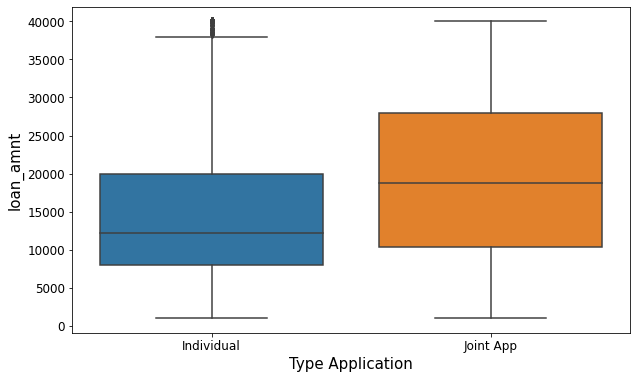

In [ ]:
#Los préstamos son individuales o conjunta de dos personas
#La gráfica evidencia la relación de esta con el monto del préstamp
f, axe = plt.subplots(figsize=(10,6))
b=sns.boxplot(x='application_type', y='loan_amnt', data=loans,ax=axe)
b.set_xlabel("Type Application",fontsize=15)
b.set_ylabel("loan_amnt",fontsize=15)
b.tick_params(labelsize=12)

In [ ]:
loans.loc[loans['loan_status']=='Does not meet the credit policy. Status:Charged Off','loan_status']='DMCP: Charged Off'
loans.loc[loans['loan_status']=='Does not meet the credit policy. Status:Fully Paid','loan_status']='DMCP:Fully Paid'
loans['loan_status'].value_counts()

Fully Paid            10747
Current                8747
Charged Off            2718
Late (31-120 days)      237
In Grace Period          84
Late (16-30 days)        54
DMCP:Fully Paid          12
DMCP: Charged Off         8
Name: loan_status, dtype: int64

Text(0.5, 1.0, 'Distribución del monto del préstamo solicitado por el prestatario por cada estado actual del préstamo')

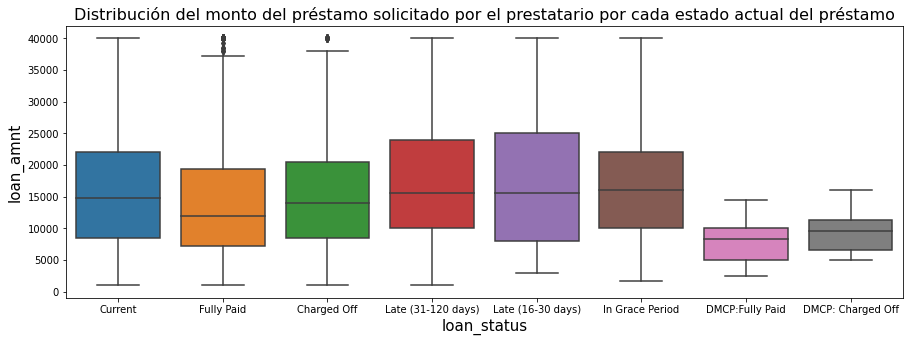

In [ ]:
#Distribución del monto del préstamo solicitado por el prestatario por cada estado actual del préstamo
f, axes = plt.subplots(1, 1, figsize=(15,5))
b = sns.boxplot(x='loan_status', y='loan_amnt', data=loans, ax=axes)
b.set_xlabel("loan_status",fontsize=15)
b.set_ylabel("loan_amnt",fontsize=15)
b.tick_params(labelsize=10)
plt.title('Distribución del monto del préstamo solicitado por el prestatario por cada estado actual del préstamo',fontsize=16)

Text(0.5, 1.0, 'Distribución de los préstamos por estado del préstamo')

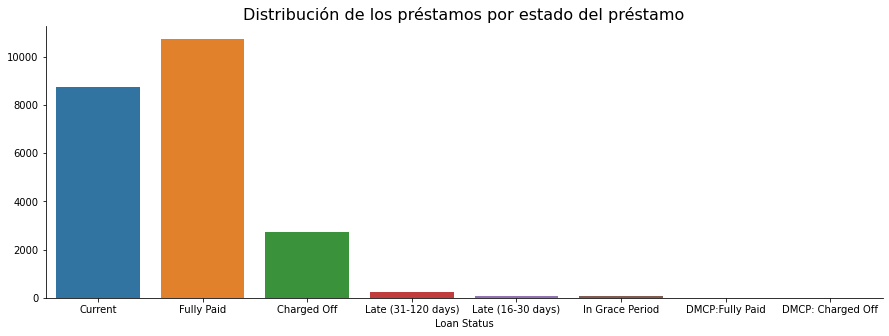

In [ ]:
#Diagrama de barras de la cantidad de personas por estado del préstamo, se evidencia que hay más personas que estan al día con sus pagos
f, axes = plt.subplots(figsize=(15,5))
sns.countplot(x='loan_status', data=loans, ax=axes)
sns.despine()
axes.set(xlabel='Loan Status', ylabel='')
plt.title('Distribución de los préstamos por estado del préstamo',fontsize=16)

Text(0.5, 1.0, 'Distribución de los préstamos por grado del préstamo')

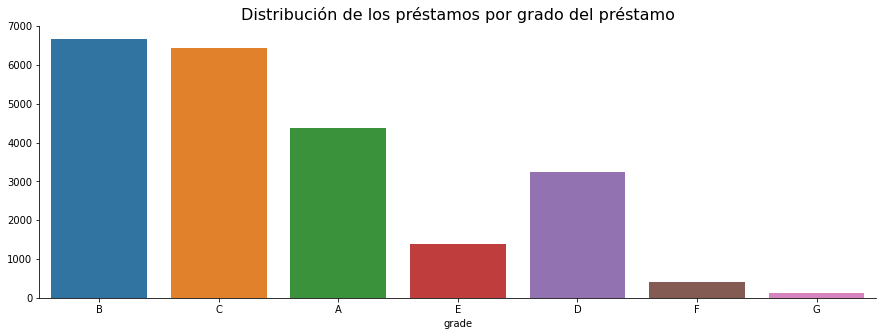

In [ ]:
#Distribución de las prestatarios por grado del préstamo
f, axes = plt.subplots(figsize=(15,5))
sns.countplot(x='grade', data=loans, ax=axes)
sns.despine()
axes.set(xlabel='grade', ylabel='')
plt.title('Distribución de los préstamos por grado del préstamo',fontsize=16)

# **Preprocesamiento de los datos**

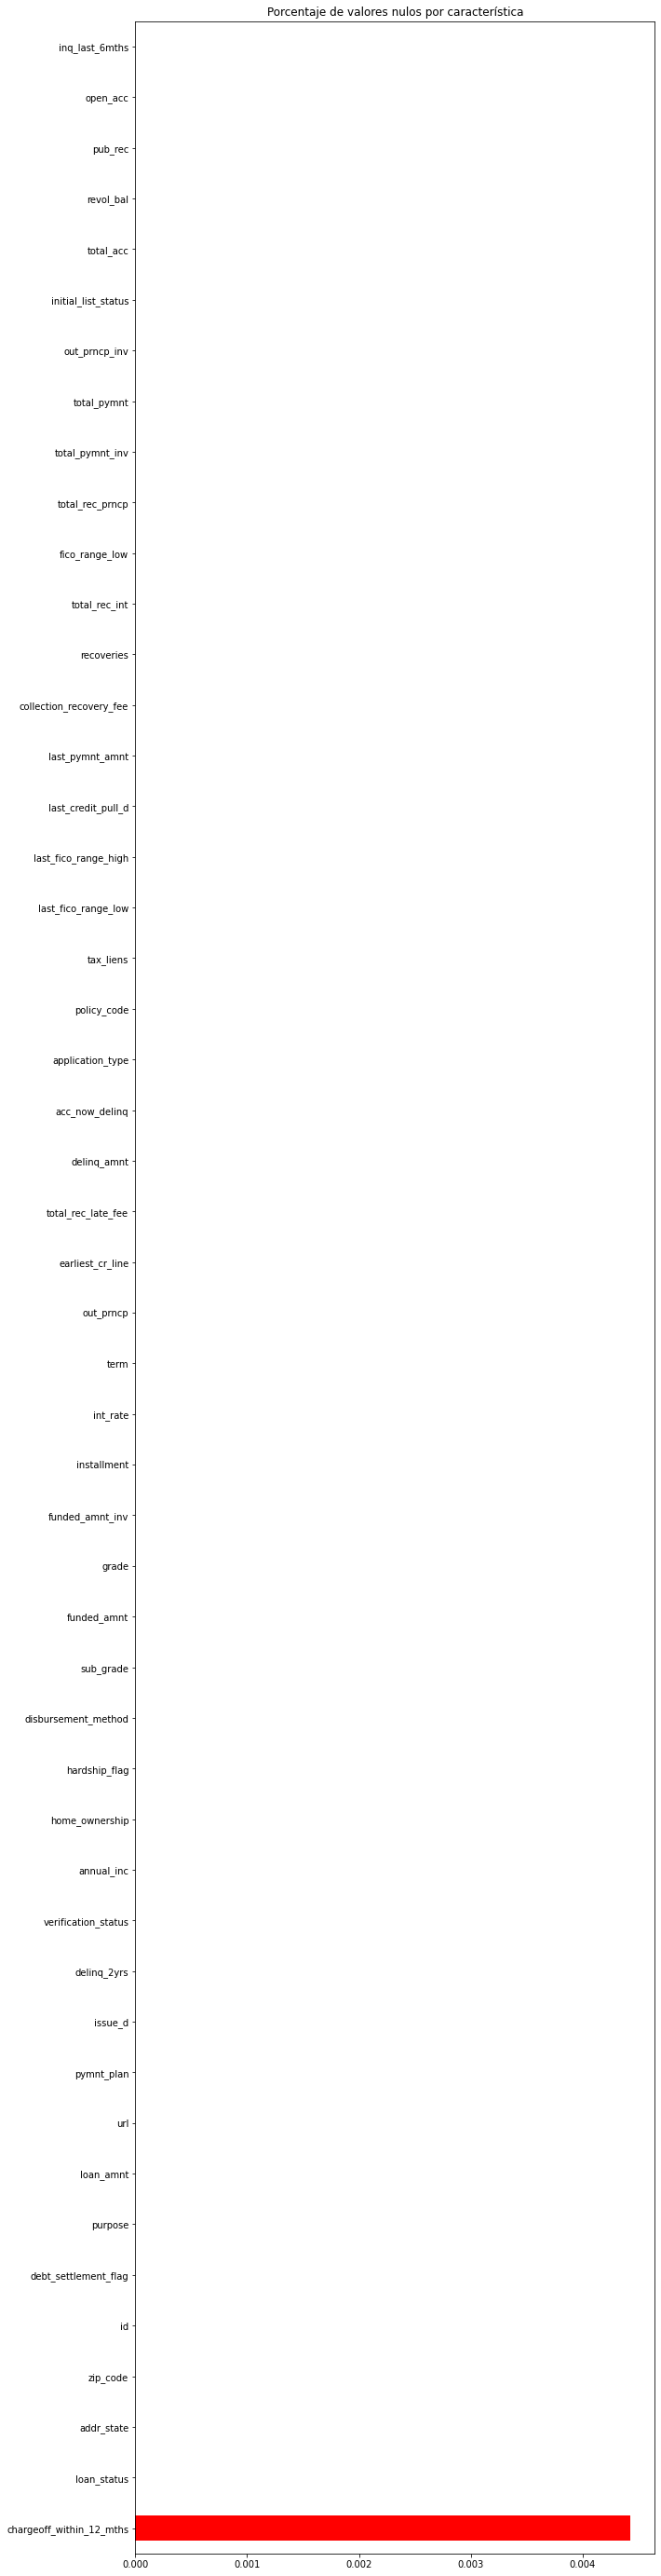

In [ ]:
plt.figure(figsize=(10,50))
((data.isnull().sum())/len(data)*100).sort_values(ascending=False)[100:150].plot.barh(title='Porcentaje de valores nulos por característica', color='red')

In [ ]:
data2 = data.drop(data.loc[:, data.isna().mean().sort_values() > 0.3].columns, axis=1)

In [ ]:
data2.head()

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,...,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,0,39651438,32000.0,32000.0,32000.0,60 months,10.49,687.65,B,B3,Public Service,10+ years,MORTGAGE,120000.0,Verified,Feb-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,919xx,CA,24.05,0.0,Oct-1981,735.0,739.0,0.0,20.0,0.0,39687.0,57.8,42.0,w,7181.91,7181.91,33676.200000,33676.20,24818.09,...,457317.0,82400.0,6.0,26901.0,31079.0,71.2,0.0,0.0,154.0,165.0,1.0,1.0,2.0,9.0,7.0,0.0,6.0,11.0,8.0,20.0,7.0,14.0,31.0,11.0,20.0,0.0,0.0,0.0,4.0,100.0,28.6,0.0,0.0,556496.0,103647.0,64100.0,72197.0,N,Cash,N
1,1,16411620,9600.0,9600.0,9600.0,36 months,12.99,323.42,C,C1,NaN,NaN,RENT,21900.0,Verified,May-2014,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,331xx,FL,10.03,0.0,Apr-2001,685.0,689.0,1.0,13.0,1.0,4509.0,38.9,20.0,w,0.00,0.00,11643.969042,11643.97,9600.00,...,4509.0,11600.0,6.0,347.0,871.0,63.7,0.0,0.0,97.0,157.0,1.0,1.0,0.0,26.0,1.0,0.0,2.0,5.0,2.0,5.0,2.0,13.0,18.0,5.0,13.0,0.0,0.0,0.0,2.0,100.0,50.0,1.0,0.0,11600.0,4509.0,2400.0,0.0,N,Cash,N
2,2,45122316,4000.0,4000.0,4000.0,36 months,6.68,122.93,A,A3,System Analyst,4 years,MORTGAGE,83000.0,Not Verified,Apr-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,Major purchase,333xx,FL,19.53,0.0,Sep-2003,780.0,784.0,0.0,16.0,0.0,1564.0,17.2,25.0,w,0.00,0.00,4368.842365,4368.84,4000.00,...,196017.0,9100.0,2.0,12251.0,5514.0,1.5,0.0,0.0,139.0,72.0,12.0,10.0,2.0,12.0,NaN,0.0,1.0,2.0,3.0,8.0,14.0,4.0,9.0,2.0,16.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,222616.0,64253.0,5600.0,76154.0,N,Cash,N
3,3,125356772,6025.0,6025.0,6025.0,36 months,10.91,197.00,B,B4,Admin assistant,10+ years,RENT,52000.0,Not Verified,Dec-2017,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,021xx,MA,9.16,1.0,Jun-2005,740.0,744.0,1.0,11.0,0.0,2706.0,12.8,25.0,w,0.00,0.00,6542.488926,6542.49,6025.00,...,5559.0,21100.0,1.0,505.0,8447.0,23.2,0.0,0.0,122.0,150.0,13.0,13.0,0.0,13.0,4.0,0.0,2.0,4.0,3.0,9.0,4.0,10.0,21.0,4.0,11.0,0.0,0.0,0.0,0.0,96.0,0.0,0.0,0.0,32227.0,5559.0,11000.0,11127.0,N,Cash,N
4,4,128490686,25000.0,25000.0,25000.0,60 months,26.30,752.96,E,E5,Coordinator,10+ years,OWN,65000.0,Verified,Feb-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,926xx,CA,36.26,0.0,Jul-1999,715.0,719.0,1.0,19.0,0.0,49461.0,24.7,33.0,w,21954.14,21954.14,9697.160000,9697.16,3045.86,...,97647.0,191500.0,10.0,5744.0,130871.0,26.3,0.0,0.0,142.0,223.0,7.0,7.0,0.0,8.0,2.0,0.0,7.0,10.0,10.0,15.0,7.0,17.0,26.0,10.0,19.0,0.0,0.0,0.0,3.0,78.8,10.0,0.0,0.0,257219.0,97647.0,179400.0,65719.0,N,Cash,N


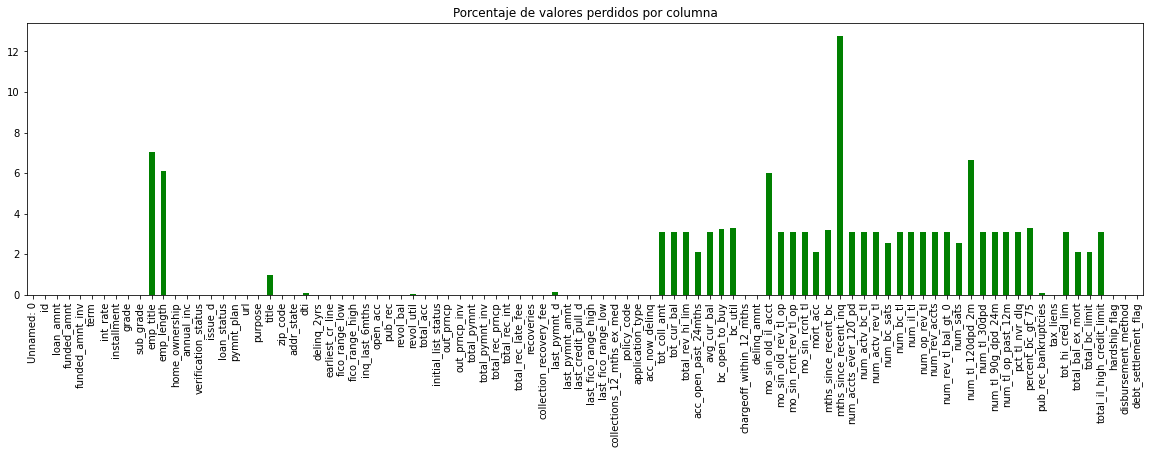

In [ ]:
plt.figure(figsize=(20,5))
((data2.isnull().sum())/len(data2)*100).plot.bar(title='Porcentaje de valores perdidos por columna', color='green')

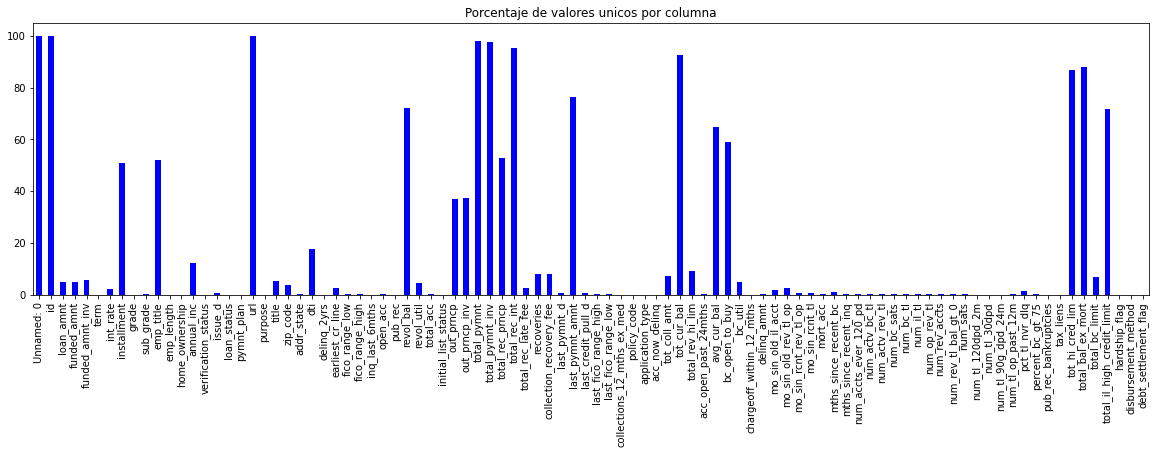

In [ ]:
plt.figure(figsize=(20,5))
((data2.nunique() / len(data2)*100)).plot.bar(title='Porcentaje de valores unicos por columna', color='blue')

In [ ]:
#Determinamos aquellas variables que tengan un porcentaje de registros únicos por cada variable mayor al valor de 0.66
threshold = 0.66
unique_percentages = data2.nunique() / len(data2)
criteria = unique_percentages > threshold
columns_to_filter = unique_percentages[criteria].keys()

In [ ]:
len(columns_to_filter)

12

In [ ]:
columns_to_filter

Index(['Unnamed: 0', 'id', 'url', 'revol_bal', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_int', 'last_pymnt_amnt', 'tot_cur_bal',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_il_high_credit_limit'],
      dtype='object')

In [ ]:
#Eliminamos las variables seleccionadas en el paso anterior
data2.drop(columns_to_filter, axis=1, inplace=True)
len(data2.columns)

82

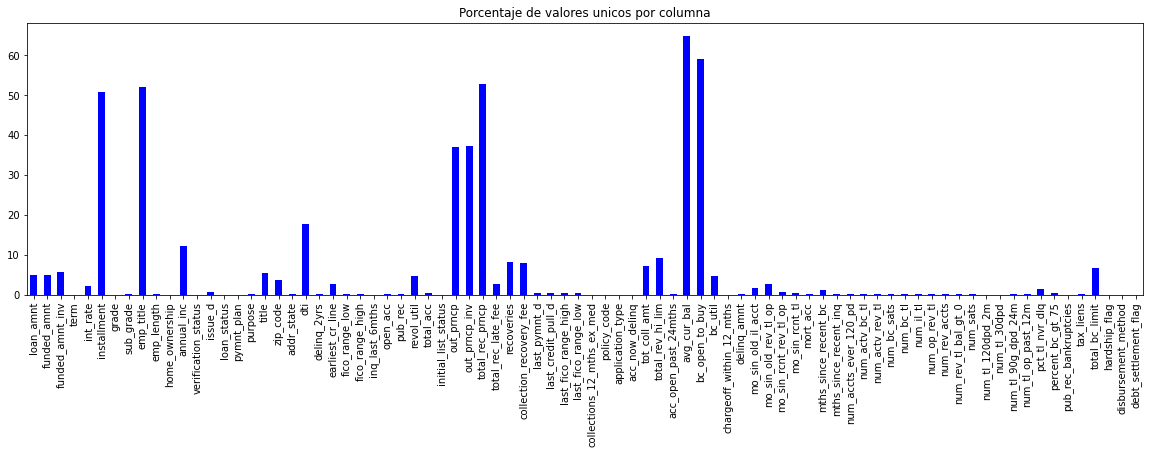

In [ ]:
plt.figure(figsize=(20,5))
((data2.nunique() / len(data2)*100)).plot.bar(title='Porcentaje de valores unicos por columna', color='blue')

In [ ]:
#Determinamos que variables son del tipo númerico y cuales son categóricas
numeric_columns = list()
categorical_columns = list()
dictionary_of_columns_with_index_to_categorical = dict()
dictionary_of_columns_with_categorical_to_index = dict()

for column in data2:
    if pd.api.types.is_numeric_dtype(data2[column]):
        numeric_columns.append(column)
    else:
        data2[column] = data2[column].astype("category")

        dictionary_of_columns_with_index_to_categorical[column] = dict()
        dictionary_of_columns_with_categorical_to_index[column] = dict()

        #Indexamos los valores (categorías) y guardamos esa información en los diccionarios
        for index, category in enumerate(data2[column].cat.categories):
            dictionary_of_columns_with_index_to_categorical[column][index] = category
            dictionary_of_columns_with_categorical_to_index[column][category] = index

        categorical_columns.append(column)

print("Cantidad de columnas numéricas",len(numeric_columns))
print("Cantidad de columnas categóricas",len(categorical_columns))

Cantidad de columnas numéricas 60
Cantidad de columnas categóricas 22


In [ ]:
#Reemplazamos los nulos con la mediana sólo de aquellas variables numéricas
median_of_numeric_columns = data2[numeric_columns].median()
data2[numeric_columns] = data2[numeric_columns].fillna(median_of_numeric_columns)

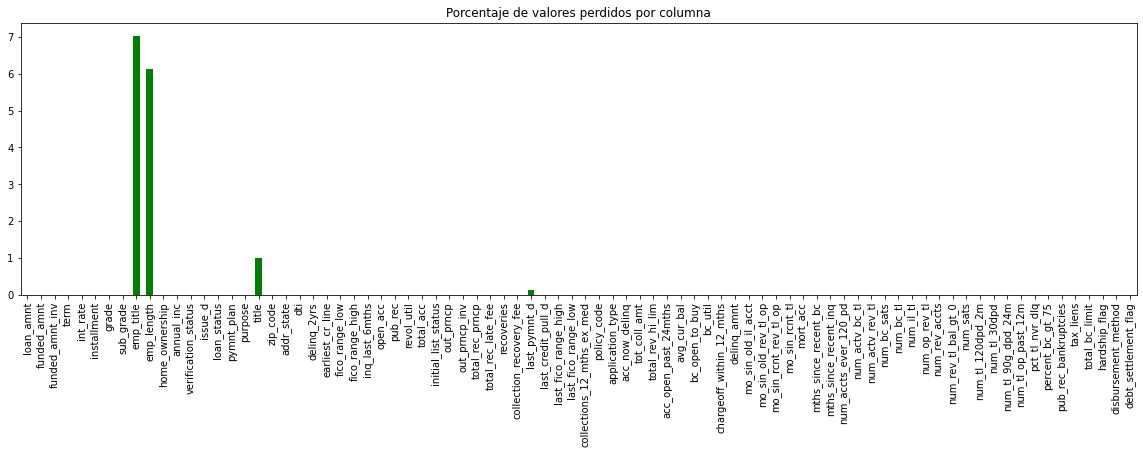

In [ ]:
plt.figure(figsize=(20,5))
((data2.isnull().sum())/len(data2)*100).plot.bar(title='Porcentaje de valores perdidos por columna', color='green')

In [ ]:
data2[['title', 'purpose']].head(10)

,title,purpose
0,Debt consolidation,debt_consolidation
1,Debt consolidation,debt_consolidation
2,Major purchase,major_purchase
3,Debt consolidation,debt_consolidation
4,Debt consolidation,debt_consolidation
5,Debt consolidation,debt_consolidation
6,Debt consolidation,debt_consolidation
7,Credit card refinancing,credit_card
8,Home buying,house
9,Debt consolidation,debt_consolidation


In [ ]:
data2 = data2.drop('title', axis=1)

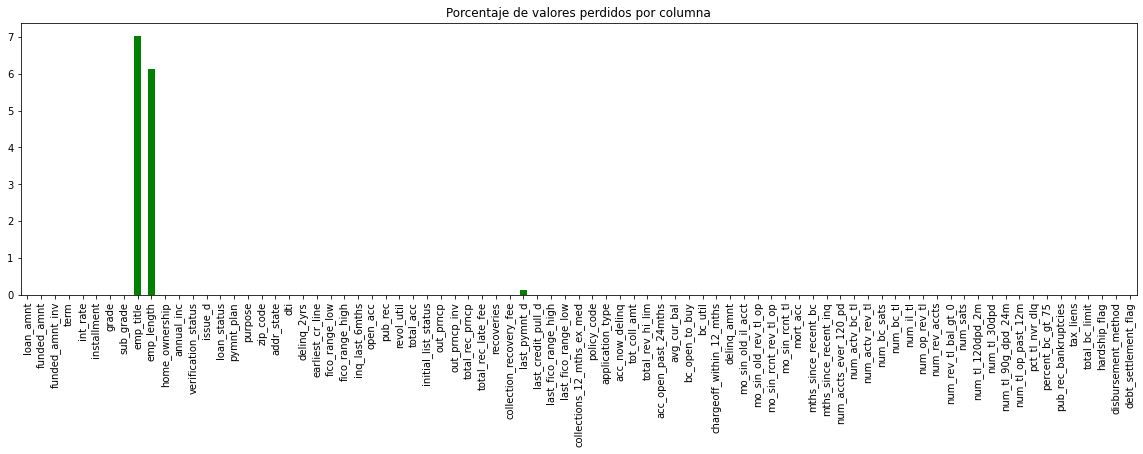

In [ ]:
plt.figure(figsize=(20,5))
((data2.isnull().sum())/len(data2)*100).plot.bar(title='Porcentaje de valores perdidos por columna', color='green')

In [ ]:
print(data2['emp_title'].nunique())
data2['emp_title'].value_counts()

11772


Teacher                                383
Manager                                308
Owner                                  195
Driver                                 162
RN                                     145
                                      ... 
Regional manager                         1
Regional manager                         1
Regional account manger contractor       1
Regional account manager                 1
 AMBULATORY RN CLINIC SUPERVISOR         1
Name: emp_title, Length: 11772, dtype: int64

In [ ]:
data2 = data2.drop('emp_title',axis=1)

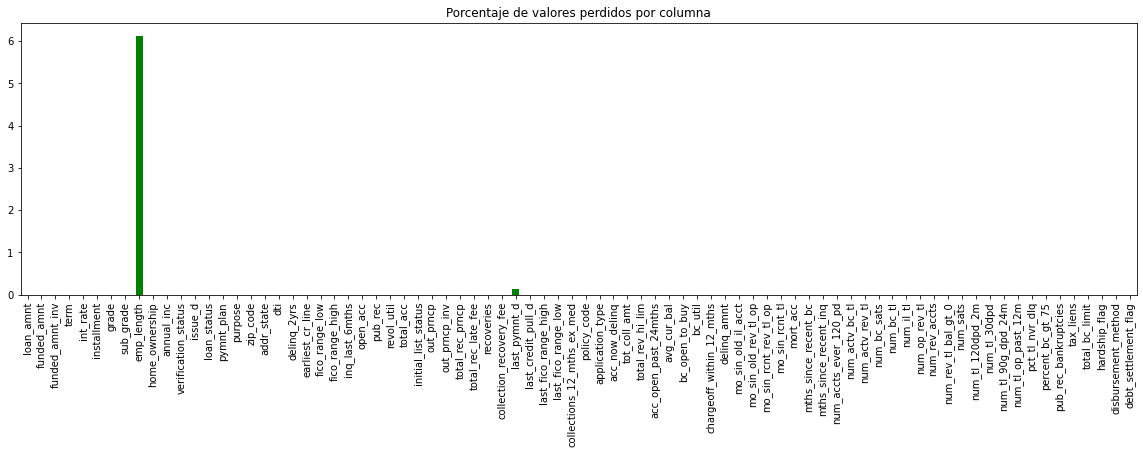

In [ ]:
plt.figure(figsize=(20,5))
((data2.isnull().sum())/len(data2)*100).plot.bar(title='Porcentaje de valores perdidos por columna', color='green')

In [ ]:
data2 = data2.drop('emp_length', axis=1)

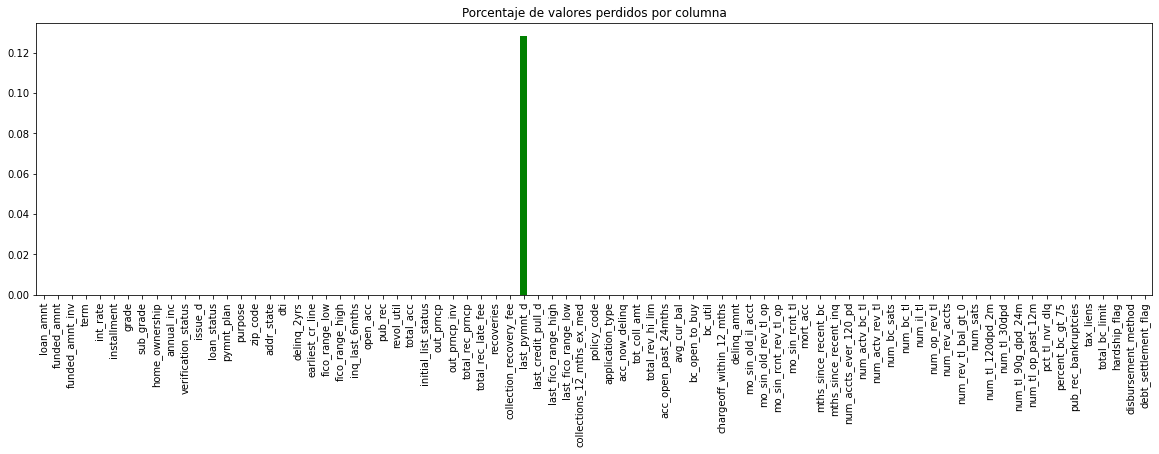

In [ ]:
plt.figure(figsize=(20,5))
((data2.isnull().sum())/len(data2)*100).plot.bar(title='Porcentaje de valores perdidos por columna', color='green')

In [ ]:
data2 = data2.dropna()
data2.isnull().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
fico_range_low                0
fico_range_high               0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_util                    0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prncp_inv                 0
total_rec_prncp               0
total_re

In [ ]:
data2 = data2.drop('grade', axis=1)
data2.shape

(22578, 78)

In [ ]:
dat= (data2.nunique()/data2.shape[0]>0.5) == True
data2 = data2.drop(dat[dat.values==True].index[0], axis=1)

In [ ]:
#Juntar las clases de loan_status
#“0”: "Fully Paid", "Current", “In Grace Period” y “Does not meet the credit policy. Status:Fully Paid”
#“1”: "Charged Off", “Late (31-120 days)”, “Late (16-30 days)” y “Does not meet the credit policy. Status:Charged Off”
#Los registros con el valor de “Default” serán descartados.

In [ ]:
data2 = data2.drop(data2.loc[data2['loan_status']=="Default"].index, axis=0)

In [ ]:
data2['target']=1
data2.loc[(data2['loan_status']=="Fully Paid"), 'target'] = 0
data2.loc[(data2['loan_status']=="Current"), 'target'] = 0
data2.loc[(data2['loan_status']=="In Grace Period"), 'target'] = 0
data2.loc[(data2['loan_status']=="Does not meet the credit policy. Status:Fully Paid"), 'target'] = 0

In [ ]:
data2 = data2.drop('loan_status', axis=1)
data2.shape

(22578, 77)

In [ ]:
lista=list()
for i in data2.columns:
  if  (data2[i].dtypes!=float) & (data2[i].dtypes!=int):
    lista.append(i)
lista
#categoricos todos los que contegan letras serían categoricos
data3 = pd.get_dummies(data2, columns=lista)

In [ ]:
data3['target'].value_counts()

0    19590
1     2988
Name: target, dtype: int64

In [ ]:
data3.shape

(22578, 1964)

In [ ]:
data3 = data3.reset_index(drop=True)

# **Conjunto de entrenamiento, validación y test**

El conjunto de datos se separa en un 90% para entrenamiento y validación, y un 10% para pruebas. Luego, del conjunto de entrenamiento y validación se separa un 85% para entrenamiento, y un 15% para validación. El número de muestras para el conjunto de entrenamiento incluye 17 272 muestras, el conjunto de validación incluye 3 048 muestras  y el conjunto de prueba incluye 2 258 muestras.

In [ ]:
from sklearn.model_selection import train_test_split

indices = data3.index.values

indices_trainval, indices_test = train_test_split(indices, test_size=0.10, random_state=0)
indices_train, indices_val =train_test_split(indices_trainval, test_size=0.15, random_state=0)

# El conjunto de entrenamiento es: data3.loc[indices_train]
# El conjunto de validación es: data3.loc[indices_val]
# El conjunto de prueba es: data3.loc[indices_test] 

print('Los primeros 5 índices del conjunto de entrenamiento son: ', indices_train[:5])

Los primeros 5 índices del conjunto de entrenamiento son:  [20939 13116  2562 12518 11157]


Se normalizan el conjunto de datos (usando el conjunto de entrenamiento), y luego se separa los valores de X_train, X_val, X_trainval, X_test y sus correspondientes Y_train, Y_val, Y_trainval, Y_test.

In [ ]:
from sklearn.preprocessing import StandardScaler

feature_columns = data3.columns.drop('target')

X = data3[feature_columns].values.astype(float)
Y = data3['target'].values.astype(int)

scaler = StandardScaler().fit(X[indices_train])

In [ ]:
X_scaled = scaler.transform(X)

X_train = X_scaled[indices_train]
X_val = X_scaled[indices_val]
X_trainval = X_scaled[indices_trainval]
X_test = X_scaled[indices_test]

Y_train = Y[indices_train]
Y_val = Y[indices_val]
Y_trainval = Y[indices_trainval]
Y_test = Y[indices_test]

In [ ]:
print ('Muestras en el conjunto de entrenamiento  :', X_train.shape[0])
print ('Muestras en el conjunto de validación     :', X_val.shape[0])
print ('Muestras en el conjunto de prueba         :', X_test.shape[0])

Muestras en el conjunto de entrenamiento  : 17272
Muestras en el conjunto de validación     : 3048
Muestras en el conjunto de prueba         : 2258


# **Implementación de los modelos**

# Medidas de calidad

In [ ]:
from sklearn import metrics

def print_binary_confusion_matrix(y_true, y_pred):
  confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
  TN = confusion_matrix[0,0]
  FN = confusion_matrix[1,0]
  FP = confusion_matrix[0,1]
  TP = confusion_matrix[1,1]
  exactitud = (TP+TN)/(TP+TN+FP+FN)
  precision = TP/(TP+FP)
  exhaustividad = TP/(TP+FN)
  f1 = 2*(precision*exhaustividad)/(precision + exhaustividad)
  print('Accuracy : {:.3f}'.format(exactitud))
  print('Precision: {:.3f}'.format(precision))
  print('Recall   : {:.3f}'.format(exhaustividad))  
  print('F1       : {:.3f}'.format(f1))
  print()

# Regresión Logística

In [ ]:
from sklearn.linear_model import LogisticRegression

**Entrenamiento y selección de hiperparámetros con Cross Validation**

In [ ]:
########################Cross validation###############################
Cs = np.logspace(-4,-1,25)
print('Se probará regresión logística con los siguientes valores de C: ')
print(Cs)
print()
mejor_modelo_LR_CV = None
mejor_score = 0
C=0
for i in Cs:
    modelo_lr = LogisticRegression(penalty='l2',C=i)
######entrenamiento con X_train##############
    modelo_lr.fit(X_train,Y_train)
    valor=modelo_lr.score(X_val,Y_val)
    if valor > mejor_score :
      mejor_score=modelo_lr.score(X_val,Y_val)
      mejor_modelo_LR_CV = modelo_lr
      C=modelo_lr.get_params()['C']

print ('Mejor valor de C: %0.4f' % mejor_modelo_LR_CV.get_params()['C'])
print ('Exactitud en el conjunto de entrenamiento: %0.4f' % mejor_modelo_LR_CV.score(X_train, Y_train))
print ('Exactitud en el conjunto de validación   : %0.4f' % mejor_modelo_LR_CV.score(X_val, Y_val))
print ('Exactitud en el conjunto de prueba       : %0.4f' % mejor_modelo_LR_CV.score(X_test,  Y_test))

Se probará regresión logística con los siguientes valores de C: 
[0.0001     0.00013335 0.00017783 0.00023714 0.00031623 0.0004217
 0.00056234 0.00074989 0.001      0.00133352 0.00177828 0.00237137
 0.00316228 0.00421697 0.00562341 0.00749894 0.01       0.01333521
 0.01778279 0.02371374 0.03162278 0.04216965 0.05623413 0.07498942
 0.1       ]

Mejor valor de C: 0.0750
Exactitud en el conjunto de entrenamiento: 0.9951
Exactitud en el conjunto de validación   : 0.9682
Exactitud en el conjunto de prueba       : 0.9659


Entrenamiento con toda la data y evaluación del desempeño

In [ ]:
# Volvemos a ajustar con el conjunto de entrenamiento + validación (entrenamiento con toda la data)
mejor_modelo_LR_CV.fit(X_trainval, Y_trainval)
print('Conjunto de entrenamiento + validación:')
print_binary_confusion_matrix(Y_train, mejor_modelo_LR_CV.predict(X_train))
print('Conjunto de prueba :')
print_binary_confusion_matrix(Y_test, mejor_modelo_LR_CV.predict(X_test))

Conjunto de entrenamiento + validación:
Accuracy : 0.994
Precision: 0.989
Recall   : 0.968
F1       : 0.979

Conjunto de prueba :
Accuracy : 0.968
Precision: 0.927
Recall   : 0.830
F1       : 0.876



Curva ROC

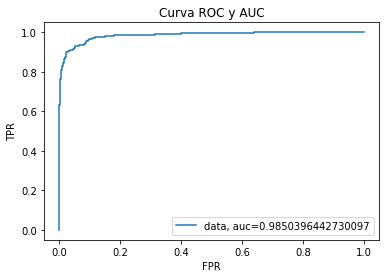

In [ ]:
# Cálculo del AUC y gráfica de la Curva ROC
y_pred_proba = mejor_modelo_LR_CV.predict_proba(X_test)[::,1]
fpr, tpr, th = roc_curve(Y_test,  y_pred_proba)
auc = roc_auc_score(Y_test, y_pred_proba)
plt.title("Curva ROC y AUC")
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=4)
plt.show()

**Entrenamiento y selección de hiperparámetros con Grid Search**

In [ ]:
#####################Parámetros del modelo##########################
Cs = np.logspace(-4,-1,25)
grid = {'C': Cs}

print('Los valores a probar en la búsqueda por grilla son:')
print(grid)
print()
########################Grid search###############################
model = LogisticRegression(penalty='l2')
modelo = GridSearchCV(estimator = model, 
                        param_grid = grid, 
                        cv = 3,          # Validación cruzada 3-fold
                        verbose=2, 
                        n_jobs = -1 )     # Paralelizar en todos los cores disponibles
modelo.fit(X_train, Y_train)
mejor_modelo_LR = modelo.best_estimator_
print()
print('Los hiperparámetros del mejor modelo son:')
print(modelo.best_params_)
print()
print('Exactitud luego de búsqueda en grilla en entrenamiento:', mejor_modelo_LR.score(X_train, Y_train))
print('Exactitud luego de búsqueda en grilla en validación:', mejor_modelo_LR.score(X_val, Y_val))
print('Exactitud luego de búsqueda en grilla en prueba:', mejor_modelo_LR.score(X_test,Y_test))

Los valores a probar en la búsqueda por grilla son:
{'C': array([0.0001    , 0.00013335, 0.00017783, 0.00023714, 0.00031623,
       0.0004217 , 0.00056234, 0.00074989, 0.001     , 0.00133352,
       0.00177828, 0.00237137, 0.00316228, 0.00421697, 0.00562341,
       0.00749894, 0.01      , 0.01333521, 0.01778279, 0.02371374,
       0.03162278, 0.04216965, 0.05623413, 0.07498942, 0.1       ])}

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.4min finished



Los hiperparámetros del mejor modelo son:
{'C': 0.05623413251903491}

Exactitud luego de búsqueda en grilla en entrenamiento: 0.9943839740620658
Exactitud luego de búsqueda en grilla en validación: 0.9678477690288714
Exactitud luego de búsqueda en grilla en prueba: 0.9645704162976085


Entrenamiento con toda la data y evaluación del desempeño

In [ ]:
# Volvemos a ajustar con el conjunto de entrenamiento + validación (entrenamiento con toda la data)
mejor_modelo_LR.fit(X_trainval, Y_trainval)
print('Conjunto de entrenamiento + validación:')
print_binary_confusion_matrix(Y_train, mejor_modelo_LR.predict(X_train))
print('Conjunto de prueba :')
print_binary_confusion_matrix(Y_test, mejor_modelo_LR.predict(X_test))

Conjunto de entrenamiento + validación:
Accuracy : 0.994
Precision: 0.989
Recall   : 0.964
F1       : 0.976

Conjunto de prueba :
Accuracy : 0.968
Precision: 0.927
Recall   : 0.827
F1       : 0.874



Curva ROC

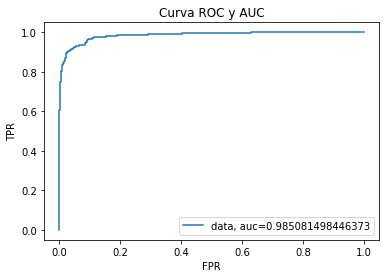

In [ ]:
# Cálculo del AUC y gráfica de la Curva ROC
y_pred_proba = mejor_modelo_LR.predict_proba(X_test)[::,1]
fpr, tpr, th = roc_curve(Y_test,  y_pred_proba)
auc = roc_auc_score(Y_test, y_pred_proba)
plt.title("Curva ROC y AUC")
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=4)
plt.show()

# Support Vector Machine

In [ ]:
from sklearn.svm import SVC

**Entrenamiento y selección de hiperparámetros con Cross Validation**

In [ ]:
########################Cross validation###############################
Cs = np.logspace(-2,2,9)  # [0.01, 0.03,  ..., 100]
gammas = np.logspace(-4,4,9)  # [0.0001, 0.001, ..., 10000]
#aplicar el cross-validation
#encontrar los mejores parametros para C y gamma
mejor_modelo_SVM_CV = None
mejor_score = 0
for C in Cs:
    for gamma in gammas:        
        model = SVC(kernel='rbf',probability=True, C=C, gamma=gamma)
#########entrenamiento con X_train############
        model.fit(X_train, Y_train)        
        score_val = model.score(X_val, Y_val)        
        if score_val > mejor_score:
            mejor_score = score_val
            mejor_modelo_SVM_CV = model

print ('Mejor valor de C: %0.4f' % mejor_modelo_SVM_CV.get_params()['C'])
print ('Mejor valor de gamma: %0.4f' % mejor_modelo_SVM_CV.get_params()['gamma'])
print ('Exactitud en el conjunto de entrenamiento: %0.4f' % mejor_modelo_SVM_CV.score(X_train, Y_train))
print ('Exactitud en el conjunto de validación   : %0.4f' % mejor_modelo_SVM_CV.score(X_val, Y_val))
print ('Exactitud en el conjunto de prueba       : %0.4f' % mejor_modelo_SVM_CV.score(X_test,  Y_test))

Mejor valor de C: 10.0000
Mejor valor de gamma: 0.0001
Exactitud en el conjunto de entrenamiento: 0.9925
Exactitud en el conjunto de validación   : 0.9148
Exactitud en el conjunto de prueba       : 0.9248


Entrenamiento con toda la data y evaluación del desempeño

In [ ]:
# Volvemos a ajustar con el conjunto de entrenamiento + validación (entrenamiento con toda la data)
mejor_modelo_SVM_CV.fit(X_trainval, Y_trainval)
print('Conjunto de entrenamiento + validación:')
print_binary_confusion_matrix(Y_train, mejor_modelo_SVM_CV.predict(X_train))
print('Conjunto de prueba :')
print_binary_confusion_matrix(Y_test, mejor_modelo_SVM_CV.predict(X_test))

Conjunto de entrenamiento + validación:
Accuracy : 0.992
Precision: 1.000
Recall   : 0.937
F1       : 0.967

Conjunto de prueba :
Accuracy : 0.925
Precision: 0.833
Recall   : 0.606
F1       : 0.702



Curva ROC

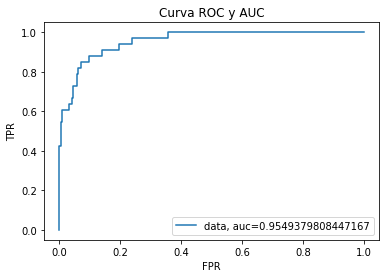

In [ ]:
# Cálculo del AUC y gráfica de la Curva ROC
y_pred_proba = mejor_modelo_SVM_CV.predict_log_proba(X_test)[::,1]
fpr, tpr, th = roc_curve(Y_test,  y_pred_proba)
auc = roc_auc_score(Y_test, y_pred_proba)
plt.title("Curva ROC y AUC")
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=4)
plt.show()

**Entrenamiento y selección de hiperparámetros con Grid Search**

In [ ]:
#####################Parámetros del modelo##########################
Cs = np.logspace(-2,2,9)  # [0.01, 0.03,  ..., 100]
gammas = np.logspace(-4,4,9)  # [0.0001, 0.001, ..., 10000]
grid = {'C': Cs,'gamma': gammas}

print('Los valores a probar en la búsqueda por grilla son:')
print(grid)
########################Grid search###############################
model = SVC(kernel='rbf',probability=True)
modelo = GridSearchCV(estimator = model, 
                        param_grid = grid, 
                        cv = 3,          # Validación cruzada 3-fold
                        verbose=2, 
                        n_jobs = -1      # Paralelizar en todos los cores disponibles
                        )
modelo.fit(X_train, Y_train)
mejor_modelo_SVM = modelo.best_estimator_
print()
print('Los hiperparámetros del mejor modelo son:')
print(modelo.best_params_)
print()
print('Exactitud luego de búsqueda en grilla en entrenamiento:', mejor_modelo_SVM.score(X_train, Y_train))
print('Exactitud luego de búsqueda en grilla en validación:', mejor_modelo_SVM.score(X_val, Y_val))
print('Exactitud luego de búsqueda en grilla en prueba:', mejor_modelo_SVM.score(X_test,Y_test))

Los valores a probar en la búsqueda por grilla son:
{'C': array([1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02]), 'gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])}
Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 45.0min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 70.2min finished



Los hiperparámetros del mejor modelo son:
{'C': 10.0, 'gamma': 0.0001}

Exactitud luego de búsqueda en grilla en entrenamiento: 0.9895373169030458
Exactitud luego de búsqueda en grilla en validación: 0.9433465085638999
Exactitud luego de búsqueda en grilla en prueba: 0.9591474245115453


Entrenamiento con toda la data y evaluación del desempeño

In [ ]:
# Volvemos a ajustar con el conjunto de entrenamiento + validación (entrenamiento con toda la data)
mejor_modelo_SVM.fit(X_trainval, Y_trainval)
print('Conjunto de entrenamiento + validación:')
print_binary_confusion_matrix(Y_train, mejor_modelo_SVM.predict(X_train))
print('Conjunto de prueba :')
print_binary_confusion_matrix(Y_test, mejor_modelo_SVM.predict(X_test))

Conjunto de entrenamiento + validación:
Accuracy : 0.989
Precision: 0.996
Recall   : 0.923
F1       : 0.958

Conjunto de prueba :
Accuracy : 0.954
Precision: 0.845
Recall   : 0.742
F1       : 0.790



Curva ROC

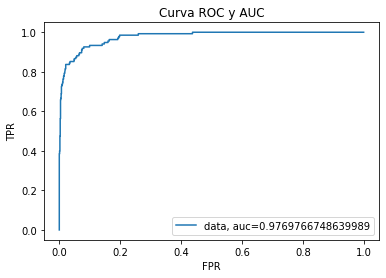

In [ ]:
# Cálculo del AUC y gráfica de la Curva ROC
y_pred_proba = mejor_modelo_SVM.predict_log_proba(X_test)[::,1]
fpr, tpr, th = roc_curve(Y_test,  y_pred_proba)
auc = roc_auc_score(Y_test, y_pred_proba)
plt.title("Curva ROC y AUC")
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=4)
plt.show()

# Redes Neuronales

Este modelo ha sido implementado en la nube de google cloud platform, por lo que acontinuación se adjuntas las capturas correspondientes de la implementación.

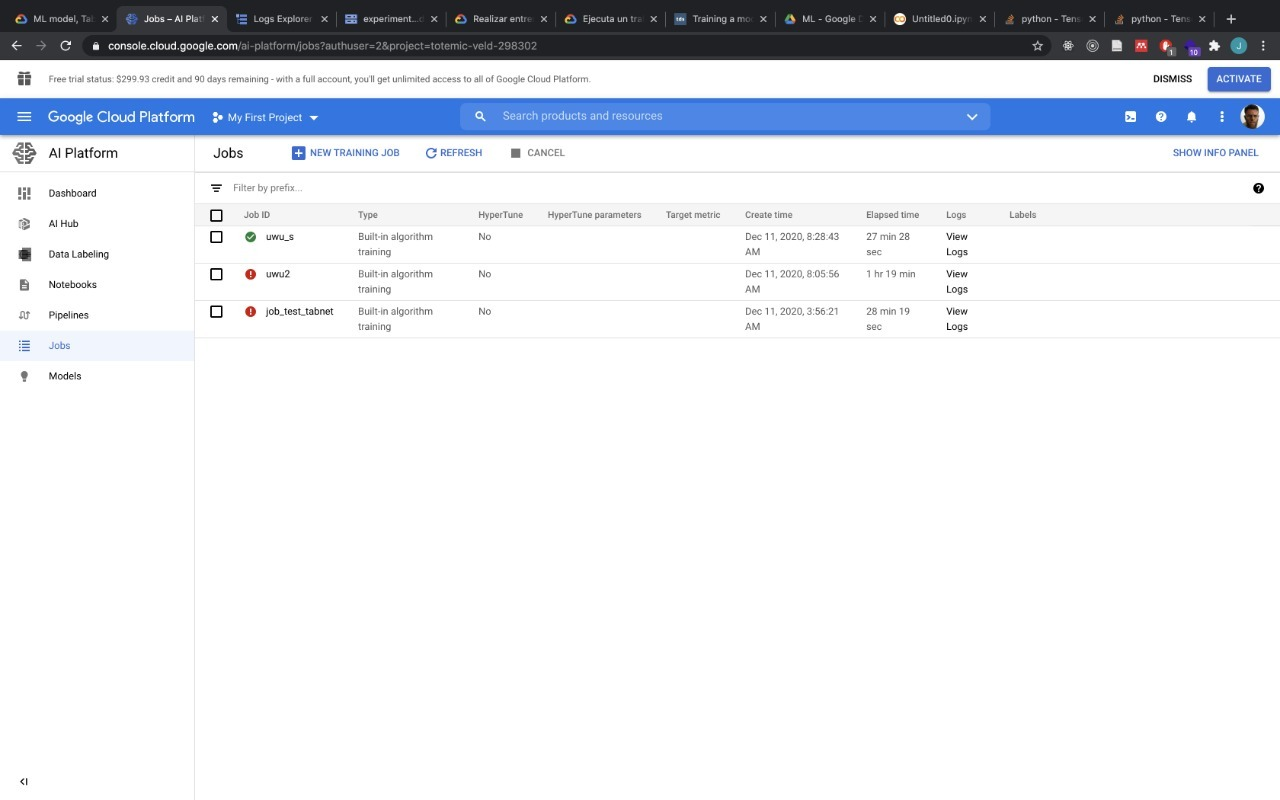

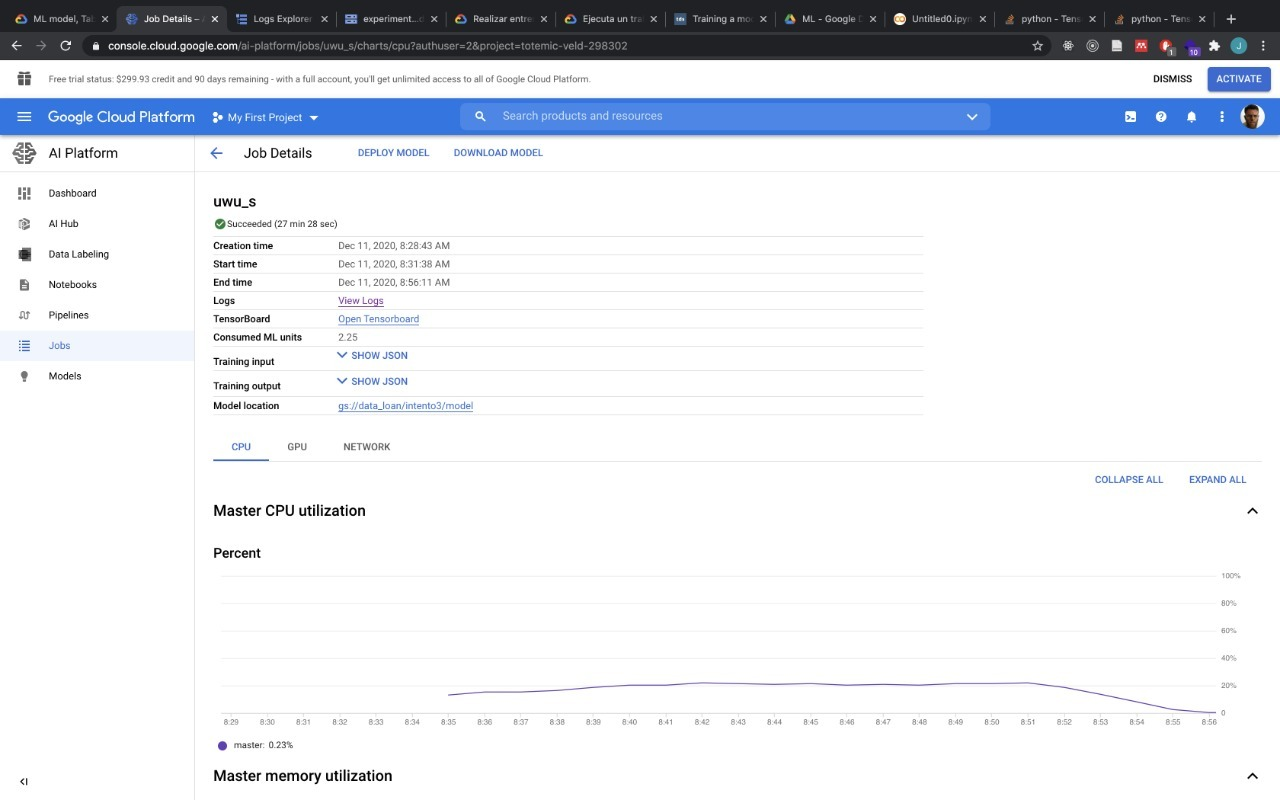

# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

**Entrenamiento y selección de hiperparámetros con Cross Validation**

In [ ]:
########################Cross validation###############################
learning_rate  = [0.1, 0.2,0.3]
n_estimators = [350,400]
max_features = [5,8,10]
max_depth = [4,7]
min_samples_leaf = [4]
#aplicar el cross-validation
mejor_modelo_GB_CV = None
mejor_score = 0
for l in learning_rate:
  for n in n_estimators:
    for f in max_features:
      for d in max_depth:
        for s in min_samples_leaf:
          model = GradientBoostingClassifier(random_state=0, learning_rate=l, n_estimators=n, max_features=f, max_depth=d, min_samples_leaf=s)
    #########entrenamiento con X_train############
          model.fit(X_train, Y_train)        
          score_val = model.score(X_val, Y_val)        
          if score_val > mejor_score:
              mejor_score = score_val
              mejor_modelo_GB_CV = model

print ('Mejor valor de max_features               : %0.4f' % mejor_modelo_GB_CV.get_params()['max_features'])
print ('Mejor valor de max_depth                  : %0.4f' % mejor_modelo_GB_CV.get_params()['max_depth'])
print ('Mejor valor de min_samples_leaf           : %0.4f' % mejor_modelo_GB_CV.get_params()['min_samples_leaf'])
print ('Mejor valor de n_estimators               : %0.4f' % mejor_modelo_GB_CV.get_params()['n_estimators'])
print ('Mejor valor de learning_rate              : %0.4f' % mejor_modelo_GB_CV.get_params()['learning_rate'])
print ('Exactitud en el conjunto de entrenamiento: %0.4f' % mejor_modelo_GB_CV.score(X_train, Y_train))
print ('Exactitud en el conjunto de validación   : %0.4f' % mejor_modelo_GB_CV.score(X_val, Y_val))
print ('Exactitud en el conjunto de prueba       : %0.4f' % mejor_modelo_GB_CV.score(X_test,  Y_test))

Mejor valor de max_features               : 10.0000
Mejor valor de max_depth                  : 7.0000
Mejor valor de min_samples_leaf           : 4.0000
Mejor valor de n_estimators               : 350.0000
Mejor valor de learning_rate              : 0.3000
Exactitud en el conjunto de entrenamiento: 0.9994
Exactitud en el conjunto de validación   : 0.9816
Exactitud en el conjunto de prueba       : 0.9748


Entrenamiento con toda la data y evaluación del desempeño

In [ ]:
# Volvemos a ajustar con el conjunto de entrenamiento + validación (entrenamiento con toda la data)
mejor_modelo_GB_CV.fit(X_trainval, Y_trainval)
print('Conjunto de entrenamiento + validación:')
print_binary_confusion_matrix(Y_trainval, mejor_modelo_GB_CV.predict(X_trainval))
print('Conjunto de prueba :')
print_binary_confusion_matrix(Y_test, mejor_modelo_GB_CV.predict(X_test))

Conjunto de entrenamiento + validación:
Accuracy : 0.998
Precision: 1.000
Recall   : 0.988
F1       : 0.994

Conjunto de prueba :
Accuracy : 0.973
Precision: 0.959
Recall   : 0.833
F1       : 0.892



Curva ROC

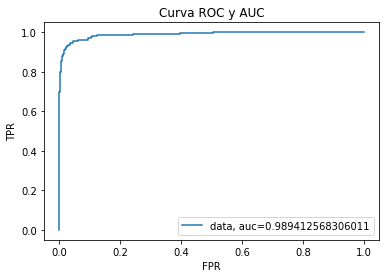

In [ ]:
# Cálculo del AUC y gráfica de la Curva ROC
y_pred_proba = mejor_modelo_GB_CV.predict_proba(X_test)[::,1]
fpr, tpr, th = roc_curve(Y_test,  y_pred_proba)
auc = roc_auc_score(Y_test, y_pred_proba)
plt.title("Curva ROC y AUC")
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=4)
plt.show()

**Entrenamiento y selección de hiperparámetros con Grid Search**

In [ ]:
#####################Parámetros del modelo##########################
learning_rate  = [0.1, 0.2,0.3]
n_estimators = [350,400]
max_features = [5,8,10]
max_depth = [4,7]
min_samples_leaf = [4]

grid = {'learning_rate': learning_rate,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

print('Los valores a probar en la búsqueda por grilla son:')
print(grid)
########################Grid search###############################
gradBoo = GradientBoostingClassifier(random_state=0)
modelo = GridSearchCV(estimator = gradBoo, 
                        param_grid = grid, 
                        cv = 3,          # Validación cruzada 3-fold
                        verbose=2, 
                        n_jobs = -1      # Paralelizar en todos los cores disponibles
                        )
modelo.fit(X_train, Y_train)
mejor_modelo_GB = modelo.best_estimator_
print()
print('Los hiperparámetros del mejor modelo son:')
print(modelo.best_params_)
print()
print('Exactitud luego de búsqueda en grilla en entrenamiento:', mejor_modelo_GB.score(X_train, Y_train))
print('Exactitud luego de búsqueda en grilla en validación:', mejor_modelo_GB.score(X_val, Y_val))
print('Exactitud luego de búsqueda en grilla en prueba:', mejor_modelo_GB.score(X_test,Y_test))

Los valores a probar en la búsqueda por grilla son:
{'learning_rate': [0.2, 0.3, 0.5], 'n_estimators': [350, 400], 'max_features': [5, 8, 10], 'max_depth': [4, 7], 'min_samples_leaf': [4]}
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  6.9min finished



Los hiperparámetros del mejor modelo son:
{'learning_rate': 0.3, 'max_depth': 7, 'max_features': 10, 'min_samples_leaf': 4, 'n_estimators': 400}

Exactitud luego de búsqueda en grilla en entrenamiento: 0.9998263084761464
Exactitud luego de búsqueda en grilla en validación: 0.9816272965879265
Exactitud luego de búsqueda en grilla en prueba: 0.9756421612046059


Entrenamiento con toda la data y evaluación del desempeño

In [ ]:
# Volvemos a ajustar con el conjunto de entrenamiento + validación (entrenamiento con toda la data)
mejor_modelo_GB.fit(X_trainval, Y_trainval)
print('Conjunto de entrenamiento + validación:')
print_binary_confusion_matrix(Y_trainval, mejor_modelo_GB.predict(X_trainval))
print('Conjunto de prueba :')
print_binary_confusion_matrix(Y_test, mejor_modelo_GB.predict(X_test))

Conjunto de entrenamiento + validación:
Accuracy : 0.999
Precision: 1.000
Recall   : 0.993
F1       : 0.996

Conjunto de prueba :
Accuracy : 0.972
Precision: 0.958
Recall   : 0.830
F1       : 0.890



Curva ROC

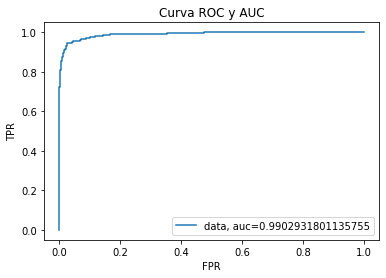

In [ ]:
# Cálculo del AUC y gráfica de la Curva ROC
y_pred_proba = mejor_modelo_GB.predict_proba(X_test)[::,1]
fpr, tpr, th = roc_curve(Y_test,  y_pred_proba)
auc = roc_auc_score(Y_test, y_pred_proba)
plt.title("Curva ROC y AUC")
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=4)
plt.show()

# Bagging

In [ ]:
from sklearn.ensemble import RandomForestClassifier

**Entrenamiento y selección de hiperparámetros con Cross Validation**

In [ ]:
########################Cross validation###############################
max_features = [ 8, 10, 12]
max_depth = [20, 30, 40]
min_samples_leaf = [1, 2, 4]
n_estimators = [200, 400, 600]
#aplicar el cross-validation
mejor_modelo_B_CV = None
mejor_score = 0
for f in max_features:
  for d in max_depth:
    for s in min_samples_leaf:
      for n in n_estimators:
        model = RandomForestClassifier(oob_score = True, n_estimators=n, max_features=f, max_depth=d, min_samples_leaf=s)
  #########entrenamiento con X_train############
        model.fit(X_train, Y_train)        
        score_val = model.score(X_val, Y_val)        
        if score_val > mejor_score:
            mejor_score = score_val
            mejor_modelo_B_CV = model

In [ ]:
print ('Mejor valor de max_features               : %0.4f' % mejor_modelo_B_CV.get_params()['max_features'])
print ('Mejor valor de max_depth                  : %0.4f' % mejor_modelo_B_CV.get_params()['max_depth'])
print ('Mejor valor de min_samples_leaf           : %0.4f' % mejor_modelo_B_CV.get_params()['min_samples_leaf'])
print ('Mejor valor de n_estimators               : %0.4f' % mejor_modelo_B_CV.get_params()['n_estimators'])
print ('Exactitud en el conjunto de entrenamiento: %0.4f' % mejor_modelo_B_CV.score(X_train, Y_train))
print ('Exactitud en el conjunto de validación   : %0.4f' % mejor_modelo_B_CV.score(X_val, Y_val))
print ('Exactitud en el conjunto de prueba       : %0.4f' % mejor_modelo_B_CV.score(X_test,  Y_test))

Mejor valor de max_features               : 12.0000
Mejor valor de max_depth                  : 40.0000
Mejor valor de min_samples_leaf           : 1.0000
Mejor valor de n_estimators               : 600.0000
Exactitud en el conjunto de entrenamiento: 0.9898
Exactitud en el conjunto de validación   : 0.9475
Exactitud en el conjunto de prueba       : 0.9384


Entrenamiento con toda la data y evaluación del desempeño

In [ ]:
# Volvemos a ajustar con el conjunto de entrenamiento + validación (entrenamiento con toda la data)
mejor_modelo_B_CV.fit(X_trainval, Y_trainval)
print('Conjunto de entrenamiento + validación:')
print_binary_confusion_matrix(Y_trainval, mejor_modelo_B_CV.predict(X_trainval))
print('Conjunto de prueba :')
print_binary_confusion_matrix(Y_test, mejor_modelo_B_CV.predict(X_test))

Conjunto de entrenamiento + validación:
Accuracy : 0.987
Precision: 1.000
Recall   : 0.901
F1       : 0.948

Conjunto de prueba :
Accuracy : 0.938
Precision: 1.000
Recall   : 0.542
F1       : 0.703



Curva ROC

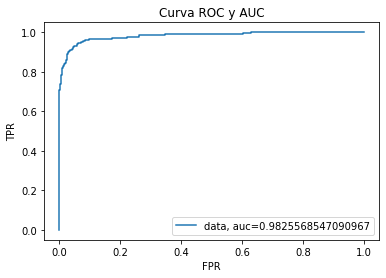

In [ ]:
# Cálculo del AUC y gráfica de la Curva ROC
y_pred_proba = mejor_modelo_B_CV.predict_proba(X_test)[::,1]
fpr, tpr, th = roc_curve(Y_test,  y_pred_proba)
auc = roc_auc_score(Y_test, y_pred_proba)
plt.title("Curva ROC y AUC")
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=4)
plt.show()

**Entrenamiento y selección de hiperparámetros con Grid Search**

In [ ]:
#####################Parámetros del modelo##########################
max_features = [ 8, 10, 12]
max_depth = [20, 30, 40]
min_samples_leaf = [1, 2, 4]
n_estimators = [200, 400, 600]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

print('Los valores a probar en la búsqueda por grilla son:')
print(grid)
########################Grid search###############################
rf = RandomForestClassifier(oob_score = True)
modelo = GridSearchCV(estimator = rf, 
                        param_grid = grid, 
                        cv = 3,          # Validación cruzada 3-fold
                        verbose=2, 
                        n_jobs = -1      # Paralelizar en todos los cores disponibles
                        )
modelo.fit(X_train, Y_train)
mejor_modelo_B = modelo.best_estimator_
print()
print('Los hiperparámetros del mejor modelo son:')
print(modelo.best_params_)
print()
print('Exactitud luego de búsqueda en grilla en entrenamiento:', mejor_modelo_B.score(X_train, Y_train))
print('Exactitud luego de búsqueda en grilla en validación:', mejor_modelo_B.score(X_val, Y_val))
print('Exactitud luego de búsqueda en grilla en prueba:', mejor_modelo_B.score(X_test,Y_test))

Los valores a probar en la búsqueda por grilla son:
{'n_estimators': [200, 400, 600], 'max_features': [8, 10, 12], 'max_depth': [20, 30, 40], 'min_samples_leaf': [1, 2, 4]}
Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 35.3min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 56.8min finished



Los hiperparámetros del mejor modelo son:
{'max_depth': 40, 'max_features': 12, 'min_samples_leaf': 1, 'n_estimators': 600}

Exactitud luego de búsqueda en grilla en entrenamiento: 0.9898679944418712
Exactitud luego de búsqueda en grilla en validación: 0.9481627296587927
Exactitud luego de búsqueda en grilla en prueba: 0.9393268379096545


Entrenamiento con toda la data y evaluación del desempeño

In [ ]:
# Volvemos a ajustar con el conjunto de entrenamiento + validación (entrenamiento con toda la data)
mejor_modelo_B.fit(X_trainval, Y_trainval)
print('Conjunto de entrenamiento + validación:')
print_binary_confusion_matrix(Y_trainval, mejor_modelo_B.predict(X_trainval))
print('Conjunto de prueba :')
print_binary_confusion_matrix(Y_test, mejor_modelo_B.predict(X_test))

Conjunto de entrenamiento + validación:
Accuracy : 0.986
Precision: 1.000
Recall   : 0.894
F1       : 0.944

Conjunto de prueba :
Accuracy : 0.938
Precision: 1.000
Recall   : 0.542
F1       : 0.703



Curva ROC

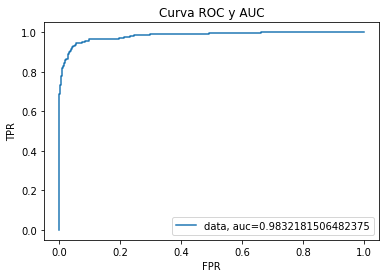

In [ ]:
# Cálculo del AUC y gráfica de la Curva ROC
y_pred_proba = mejor_modelo_B.predict_proba(X_test)[::,1]
fpr, tpr, th = roc_curve(Y_test,  y_pred_proba)
auc = roc_auc_score(Y_test, y_pred_proba)
plt.title("Curva ROC y AUC")
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=4)
plt.show()

# Apilamiento

In [ ]:
from sklearn import model_selection
from mlxtend.classifier import StackingClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


**Apilamiento con los modelos con ajuste de hiper parámetros con Grid search**

In [ ]:
#####################Selección de modelo##########################
clf1 = mejor_modelo_SVM
clf2 = mejor_modelo_GB
clf3 = mejor_modelo_B
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('3-fold cross validation:\n')
for clf, label in zip([clf1, clf2, clf3, sclf], ['SVM','Gradient Boosting', 'Bagging','StackingClassifier']):
    scores = model_selection.cross_val_score(clf, X_val, Y_val, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


sclf.fit(X_train, Y_train)
print()
print('Exactitud luego de búsqueda en grilla en entrenamiento:', sclf.score(X_train, Y_train))
print('Exactitud luego de búsqueda en grilla en validación:', sclf.score(X_val, Y_val))
print('Exactitud luego de búsqueda en grilla en prueba:', sclf.score(X_test,Y_test))

3-fold cross validation:

Accuracy: 0.89 (+/- 0.01) [SVM]
Accuracy: 0.95 (+/- 0.01) [Gradient Boosting]
Accuracy: 0.87 (+/- 0.00) [Bagging]
Accuracy: 0.91 (+/- 0.00) [StackingClassifier]

Exactitud luego de búsqueda en grilla en entrenamiento: 1.0
Exactitud luego de búsqueda en grilla en validación: 1.0
Exactitud luego de búsqueda en grilla en prueba: 0.9751332149200711


Entrenamiento con toda la data y evaluación del desempeño

In [ ]:
# Volvemos a ajustar con el conjunto de entrenamiento + validación (entrenamiento con toda la data)
sclf.fit(X_trainval, Y_trainval)
print('Conjunto de entrenamiento + validación:')
print_binary_confusion_matrix(Y_trainval, sclf.predict(X_trainval))
print('Conjunto de prueba :')
print_binary_confusion_matrix(Y_test, sclf.predict(X_test))

Conjunto de entrenamiento + validación:
Accuracy : 1.000
Precision: 1.000
Recall   : 1.000
F1       : 1.000

Conjunto de prueba :
Accuracy : 0.975
Precision: 0.933
Recall   : 0.848
F1       : 0.889



Curva ROC

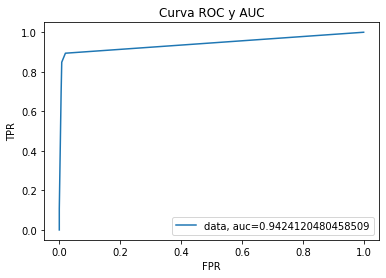

In [ ]:
# Cálculo del AUC y gráfica de la Curva ROC
y_pred_proba = sclf.predict_proba(X_test)[::,1]
fpr, tpr, th = roc_curve(Y_test,  y_pred_proba)
auc = roc_auc_score(Y_test, y_pred_proba)
plt.title("Curva ROC y AUC")
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=4)
plt.show()